# E-commerce Business Analytics: Customer Behavior & Revenue Optimization.
# Author: Pradumna Patki.

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import scipy.stats as stats

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 E-commerce Analytics Project Initialized")
print("=" * 50)

📊 E-commerce Analytics Project Initialized


### 1. DATA GENERATION & SIMULATION

In [2]:
print("🔄 Generating realistic e-commerce dataset...")

# Set random seed for reproducibility
np.random.seed(42)

# Generate date range (2 years of data)
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 12, 31)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create synthetic but realistic e-commerce data
n_customers = 5000
n_products = 200
n_transactions = 50000

# Customer data
customers = pd.DataFrame({
    'customer_id': range(1, n_customers + 1),
    'registration_date': np.random.choice(date_range[:365], n_customers),
    'customer_segment': np.random.choice(['Premium', 'Regular', 'Budget'], n_customers, p=[0.2, 0.5, 0.3]),
    'acquisition_channel': np.random.choice(['Organic', 'Paid Search', 'Social Media', 'Email', 'Referral'], 
                                          n_customers, p=[0.3, 0.25, 0.2, 0.15, 0.1]),
    'country': np.random.choice(['USA', 'Canada', 'UK', 'Germany', 'France', 'Australia'], 
                               n_customers, p=[0.4, 0.15, 0.15, 0.12, 0.10, 0.08])
})

# Product data
products = pd.DataFrame({
    'product_id': range(1, n_products + 1),
    'category': np.random.choice(['Electronics', 'Clothing', 'Home & Garden', 'Books', 'Sports', 'Beauty'], 
                                n_products, p=[0.25, 0.20, 0.15, 0.15, 0.15, 0.10]),
    'subcategory': np.random.choice(['Smartphone', 'Laptop', 'Headphones', 'Shirt', 'Shoes', 'Furniture', 
                                   'Fiction', 'Sports Equipment', 'Skincare', 'Home Decor'], n_products),
    'price': np.random.lognormal(mean=3.5, sigma=1.2, size=n_products).round(2),
    'cost': lambda x: (x * np.random.uniform(0.3, 0.7, len(x))).round(2)
})
products['cost'] = (products['price'] * np.random.uniform(0.3, 0.7, len(products))).round(2)

# Transaction data with realistic patterns
transactions = []
for i in range(n_transactions):
    customer_id = np.random.randint(1, n_customers + 1)
    customer_segment = customers[customers['customer_id'] == customer_id]['customer_segment'].iloc[0]
    
    # Adjust purchase probability based on segment
    if customer_segment == 'Premium':
        quantity = np.random.choice([1, 2, 3, 4], p=[0.4, 0.3, 0.2, 0.1])
        product_price_bias = 1.5  # Premium customers buy more expensive items
    elif customer_segment == 'Regular':
        quantity = np.random.choice([1, 2, 3], p=[0.6, 0.3, 0.1])
        product_price_bias = 1.0
    else:  # Budget
        quantity = np.random.choice([1, 2], p=[0.8, 0.2])
        product_price_bias = 0.6
    
    # Select products with price bias
    product_weights = (products['price'] * product_price_bias) / (products['price'] * product_price_bias).sum()
    product_id = np.random.choice(products['product_id'], p=product_weights)
    
    # Generate realistic transaction date (higher volume in recent months)
    if np.random.random() < 0.6:  # 60% of transactions in last 6 months
        transaction_date = np.random.choice(date_range[-180:])
    else:
        transaction_date = np.random.choice(date_range[:-180])
    
    transactions.append({
        'transaction_id': i + 1,
        'customer_id': customer_id,
        'product_id': product_id,
        'transaction_date': transaction_date,
        'quantity': quantity,
        'discount_percent': np.random.choice([0, 5, 10, 15, 20], p=[0.5, 0.2, 0.15, 0.1, 0.05])
    })

transactions_df = pd.DataFrame(transactions)

# Merge to get complete transaction data
df = transactions_df.merge(products[['product_id', 'category', 'price', 'cost']], on='product_id')
df = df.merge(customers[['customer_id', 'customer_segment', 'acquisition_channel', 'country', 'registration_date']], 
              on='customer_id')

# Calculate derived metrics
df['gross_revenue'] = df['price'] * df['quantity']
df['discount_amount'] = df['gross_revenue'] * (df['discount_percent'] / 100)
df['net_revenue'] = df['gross_revenue'] - df['discount_amount']
df['total_cost'] = df['cost'] * df['quantity']
df['profit'] = df['net_revenue'] - df['total_cost']
df['profit_margin'] = (df['profit'] / df['net_revenue']) * 100

print(f"✅ Generated dataset with {len(df)} transactions")
print(f"📅 Date range: {df['transaction_date'].min()} to {df['transaction_date'].max()}")
print(f"👥 Customers: {df['customer_id'].nunique()}")
print(f"🛍️ Products: {df['product_id'].nunique()}")

🔄 Generating realistic e-commerce dataset...
✅ Generated dataset with 50000 transactions
📅 Date range: 2023-01-01 00:00:00 to 2024-12-31 00:00:00
👥 Customers: 5000
🛍️ Products: 200


### 2. EXPLORATORY DATA ANALYSIS

In [3]:
# Basic dataset information
print("\n📋 Dataset Overview:")
print(f"Dataset Shape: {df.shape}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nData Types:")
print(df.dtypes)

print("\n📊 Missing Values:")
print(df.isnull().sum())

# Statistical Summary
print("\n📈 Statistical Summary:")
print(df.describe())


📋 Dataset Overview:
Dataset Shape: (50000, 19)
Memory Usage: 16.45 MB

Data Types:
transaction_id                  int64
customer_id                     int64
product_id                      int64
transaction_date       datetime64[ns]
quantity                        int64
discount_percent                int64
category                       object
price                         float64
cost                          float64
customer_segment               object
acquisition_channel            object
country                        object
registration_date      datetime64[ns]
gross_revenue                 float64
discount_amount               float64
net_revenue                   float64
total_cost                    float64
profit                        float64
profit_margin                 float64
dtype: object

📊 Missing Values:
transaction_id         0
customer_id            0
product_id             0
transaction_date       0
quantity               0
discount_percent       0
category   

### 3. KEY PERFORMANCE INDICATORS (KPIs) ANALYSIS

In [4]:
print("\n💰 Calculating Key E-commerce KPIs...")

# Convert transaction_date to datetime for time-based analysis
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['year_month'] = df['transaction_date'].dt.to_period('M')

# 1. REVENUE METRICS
total_revenue = df['net_revenue'].sum()
total_profit = df['profit'].sum()
overall_profit_margin = (total_profit / total_revenue) * 100

print(f"\n💵 REVENUE METRICS:")
print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Total Profit: ${total_profit:,.2f}")
print(f"Overall Profit Margin: {overall_profit_margin:.2f}%")

# 2. CUSTOMER METRICS
total_customers = df['customer_id'].nunique()
avg_order_value = df.groupby('transaction_id')['net_revenue'].first().mean()

# Customer Lifetime Value (CLV) calculation
customer_metrics = df.groupby('customer_id').agg({
    'net_revenue': ['sum', 'count', 'mean'],
    'transaction_date': ['min', 'max'],
    'profit': 'sum'
}).round(2)

customer_metrics.columns = ['total_revenue', 'total_orders', 'avg_order_value', 'first_purchase', 'last_purchase', 'total_profit']

# Calculate customer lifespan in days
customer_metrics['customer_lifespan'] = (customer_metrics['last_purchase'] - customer_metrics['first_purchase']).dt.days
customer_metrics['customer_lifespan'] = customer_metrics['customer_lifespan'].fillna(0)

# Average Customer Lifetime Value
avg_clv = customer_metrics['total_revenue'].mean()

print(f"\n👥 CUSTOMER METRICS:")
print(f"Total Customers: {total_customers:,}")
print(f"Average Order Value (AOV): ${avg_order_value:.2f}")
print(f"Average Customer Lifetime Value: ${avg_clv:.2f}")

# 3. PURCHASE FREQUENCY & RETENTION
purchase_frequency = df.groupby('customer_id')['transaction_id'].count()
avg_purchase_frequency = purchase_frequency.mean()

# Customer segmentation by purchase frequency
customer_segments = pd.cut(purchase_frequency, bins=[0, 1, 3, 5, float('inf')], 
                          labels=['One-time', 'Occasional', 'Regular', 'Frequent'])
segment_distribution = customer_segments.value_counts(normalize=True) * 100

print(f"\n🔄 PURCHASE BEHAVIOR:")
print(f"Average Purchase Frequency: {avg_purchase_frequency:.2f} orders per customer")
print("\nCustomer Segmentation by Purchase Frequency:")
for segment, percentage in segment_distribution.items():
    print(f"{segment}: {percentage:.1f}%")

# 4. PRODUCT PERFORMANCE
product_performance = df.groupby(['category']).agg({
    'net_revenue': 'sum',
    'quantity': 'sum',
    'profit': 'sum',
    'transaction_id': 'count'
}).round(2)

product_performance.columns = ['total_revenue', 'units_sold', 'total_profit', 'total_transactions']
product_performance['avg_selling_price'] = product_performance['total_revenue'] / product_performance['units_sold']
product_performance['profit_margin'] = (product_performance['total_profit'] / product_performance['total_revenue']) * 100

print(f"\n🏷️ TOP PERFORMING CATEGORIES:")
top_categories = product_performance.sort_values('total_revenue', ascending=False)
print(top_categories.head())

# 5. TIME-BASED ANALYSIS
monthly_metrics = df.groupby('year_month').agg({
    'net_revenue': 'sum',
    'customer_id': 'nunique',
    'transaction_id': 'count',
    'profit': 'sum'
}).round(2)

monthly_metrics.columns = ['monthly_revenue', 'unique_customers', 'total_transactions', 'monthly_profit']
monthly_metrics['revenue_growth'] = monthly_metrics['monthly_revenue'].pct_change() * 100

print(f"\n📅 MONTHLY PERFORMANCE (Last 6 months):")
print(monthly_metrics.tail(6))


💰 Calculating Key E-commerce KPIs...

💵 REVENUE METRICS:
Total Revenue: $26,788,663.71
Total Profit: $11,348,579.15
Overall Profit Margin: 42.36%

👥 CUSTOMER METRICS:
Total Customers: 5,000
Average Order Value (AOV): $535.77
Average Customer Lifetime Value: $5357.73

🔄 PURCHASE BEHAVIOR:
Average Purchase Frequency: 10.00 orders per customer

Customer Segmentation by Purchase Frequency:
Frequent: 92.9%
Regular: 5.9%
Occasional: 1.1%
One-time: 0.0%

🏷️ TOP PERFORMING CATEGORIES:
               total_revenue  units_sold  total_profit  total_transactions  \
category                                                                     
Electronics      19363267.99       27528    7831584.98               18140   
Clothing          2238334.34        9206    1374254.31                6103   
Home & Garden     1998893.04       11165     725248.71                7362   
Books             1273549.49       11181     579236.56                7359   
Sports            1011631.53        9897     3875

### 4. ADVANCED ANALYTICS & INSIGHTS

In [5]:
# Customer Cohort Analysis
def cohort_analysis(df):
    df['order_period'] = df['transaction_date'].dt.to_period('M')
    
    # Get customer's first purchase month
    df['cohort_group'] = df.groupby('customer_id')['transaction_date'].transform('min').dt.to_period('M')
    
    # Calculate period number
    def get_period_number(df):
        return (df['order_period'] - df['cohort_group']).apply(attrgetter('n'))
    
    from operator import attrgetter
    df['period_number'] = get_period_number(df)
    
    # Create cohort table
    cohort_data = df.groupby(['cohort_group', 'period_number'])['customer_id'].nunique().reset_index()
    cohort_counts = cohort_data.pivot(index='cohort_group', columns='period_number', values='customer_id')
    
    # Calculate cohort sizes
    cohort_sizes = df.groupby('cohort_group')['customer_id'].nunique()
    
    # Calculate retention rates
    retention_table = cohort_counts.divide(cohort_sizes, axis=0)
    
    return retention_table

retention_rates = cohort_analysis(df.copy())
print("✅ Cohort analysis completed")

# RFM Analysis
def rfm_analysis(df):
    current_date = df['transaction_date'].max()
    
    rfm = df.groupby('customer_id').agg({
        'transaction_date': lambda x: (current_date - x.max()).days,
        'transaction_id': 'count',
        'net_revenue': 'sum'
    }).round(2)
    
    rfm.columns = ['recency', 'frequency', 'monetary']
    
    # Create RFM segments
    rfm['r_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
    rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
    rfm['m_score'] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])
    
    rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)
    
    # Define customer segments
    def segment_customers(row):
        if row['rfm_score'] in ['555', '554', '544', '545', '454', '455', '445']:
            return 'Champions'
        elif row['rfm_score'] in ['543', '444', '435', '355', '354', '345', '344', '335']:
            return 'Loyal Customers'
        elif row['rfm_score'] in ['512', '511', '422', '421', '412', '411', '311']:
            return 'Potential Loyalists'
        elif row['rfm_score'] in ['533', '532', '531', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414', '415', '315', '314', '313']:
            return 'New Customers'
        elif row['rfm_score'] in ['155', '154', '144', '214', '215', '115', '114']:
            return 'At Risk'
        elif row['rfm_score'] in ['155', '254', '245']:
            return "Can't Lose Them"
        else:
            return 'Others'
    
    rfm['customer_segment'] = rfm.apply(segment_customers, axis=1)
    
    return rfm

rfm_data = rfm_analysis(df.copy())
rfm_summary = rfm_data['customer_segment'].value_counts()
print("✅ RFM analysis completed")

✅ Cohort analysis completed
✅ RFM analysis completed


### 5. VISUALIZATIONS

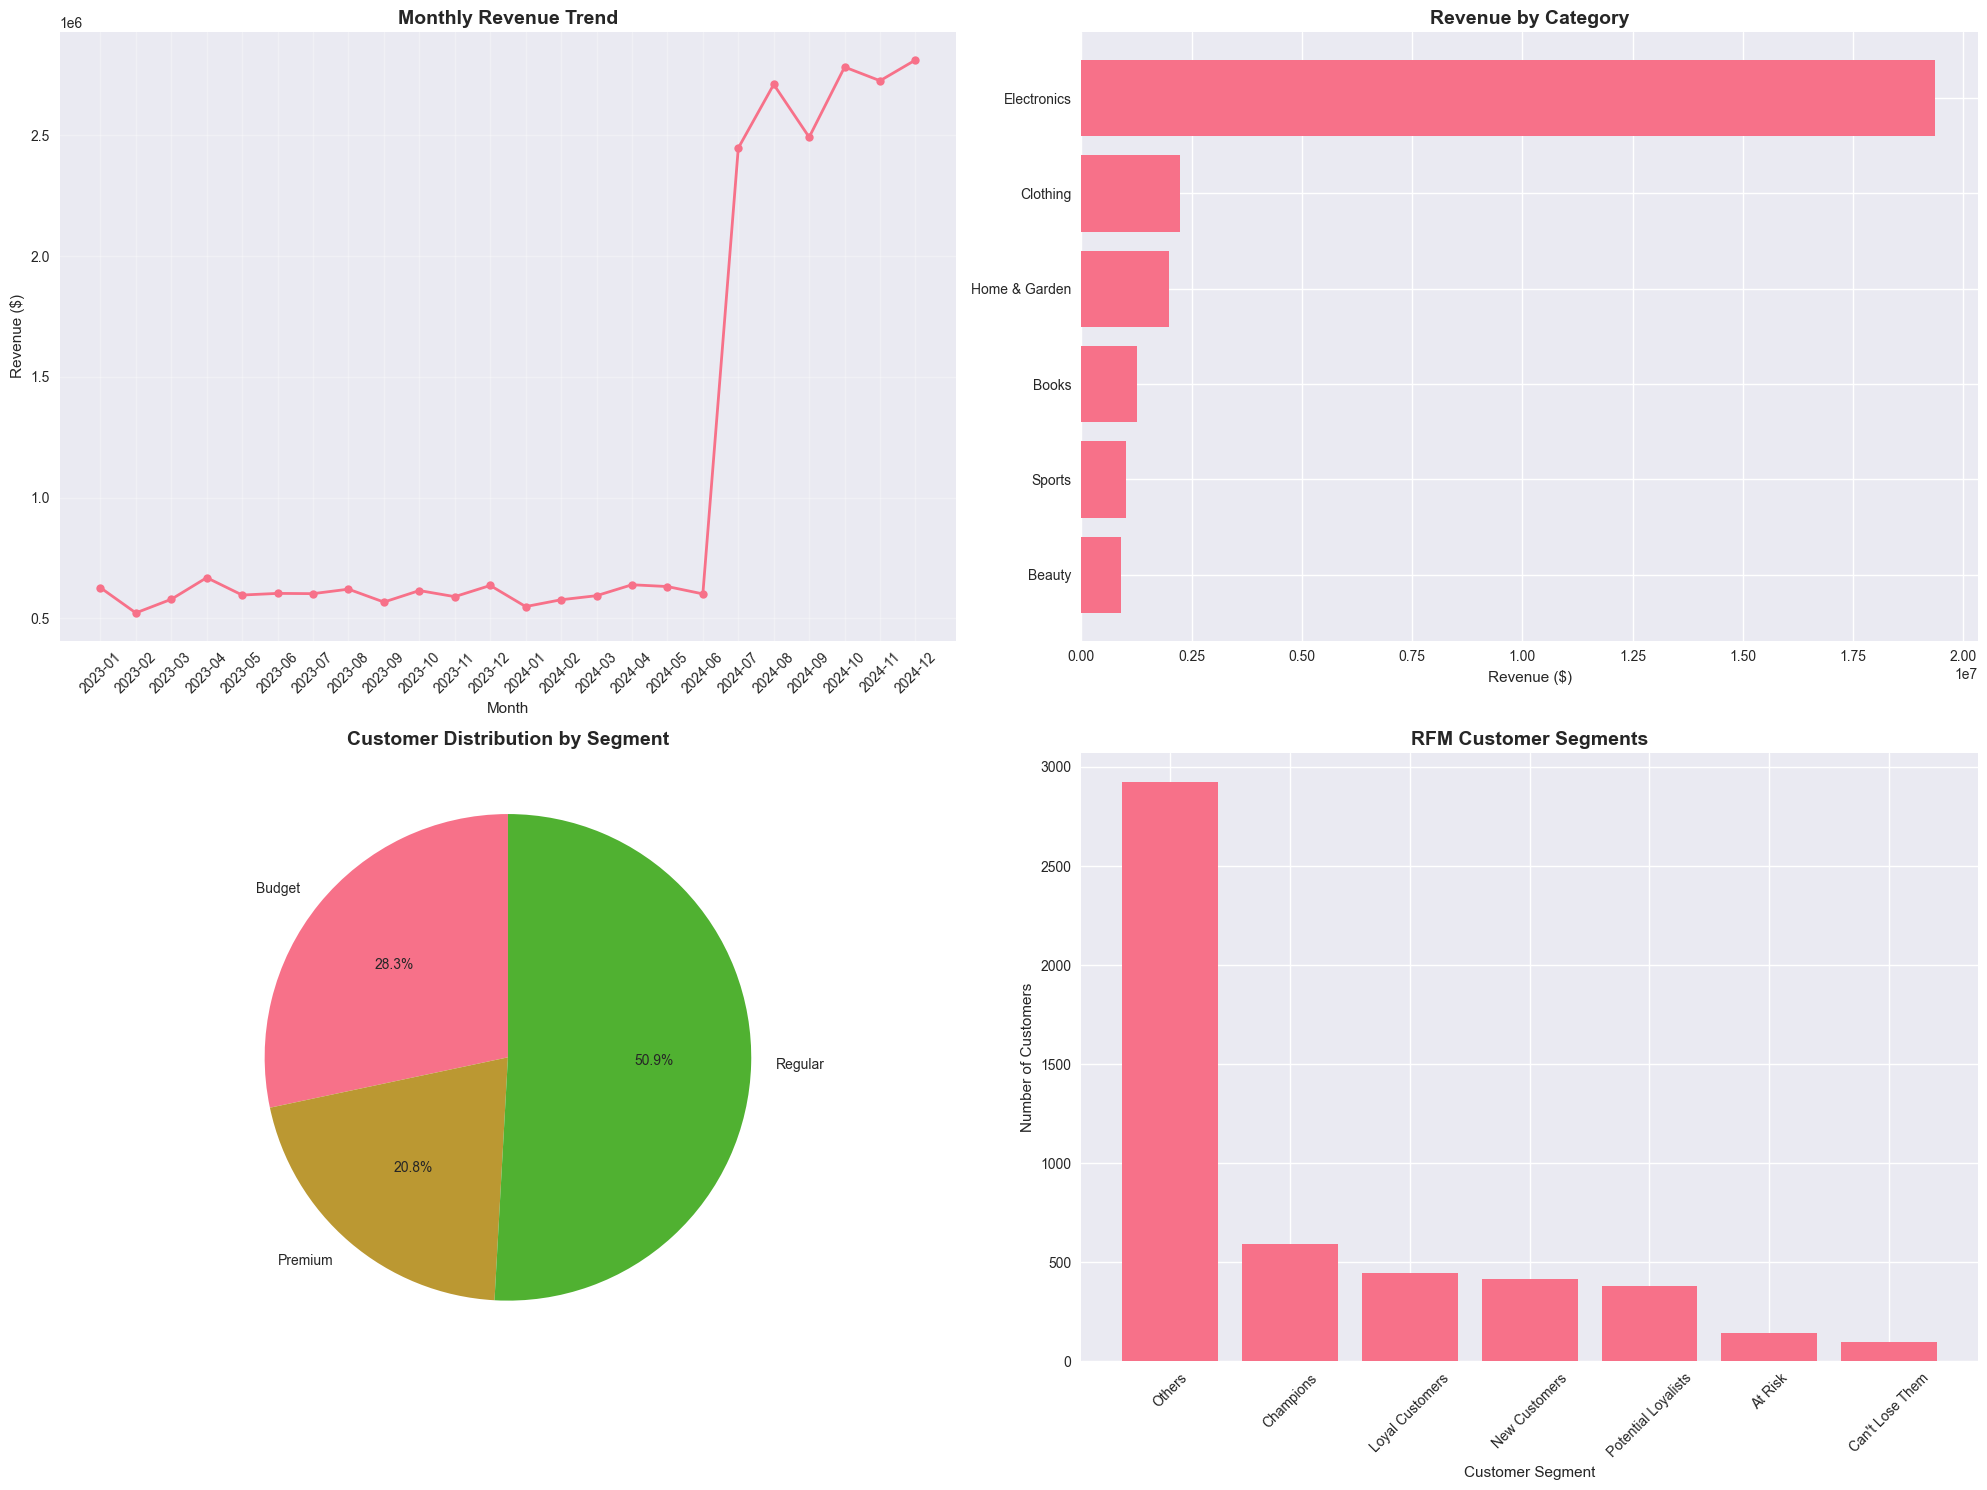

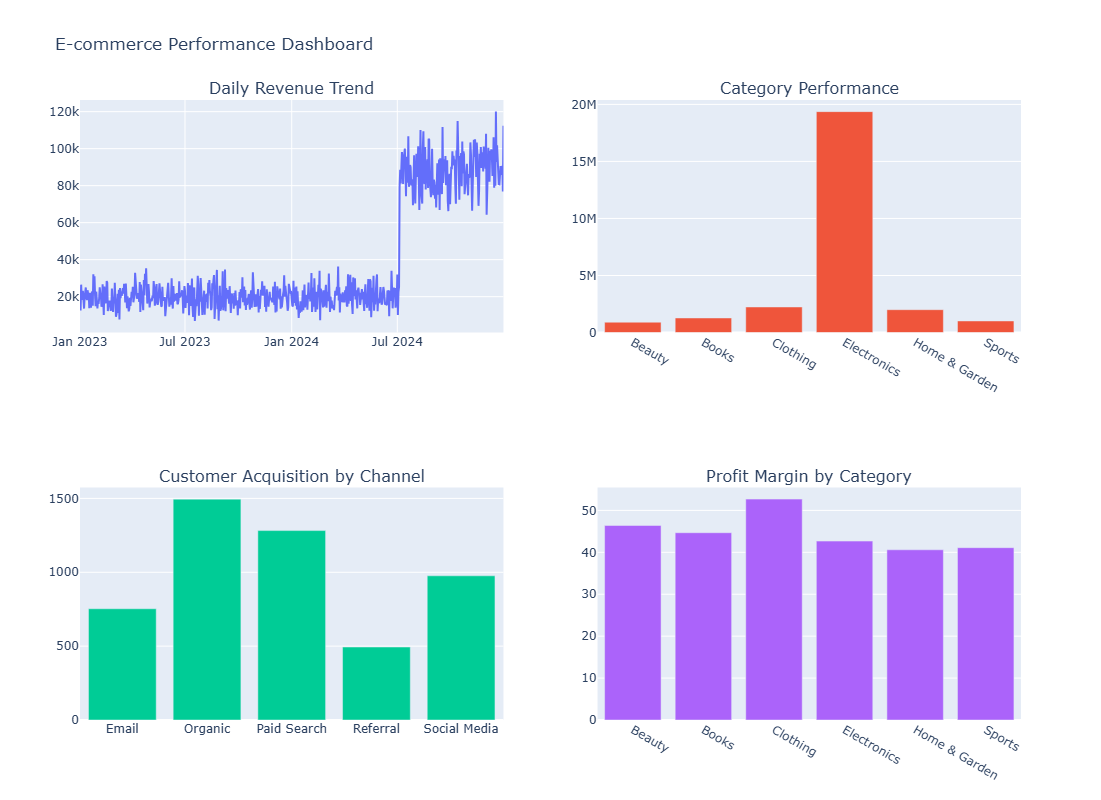

In [6]:
# Set up the plotting parameters
plt.rcParams['figure.figsize'] = (15, 10)

# 1. Revenue Trend Over Time
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# Monthly Revenue Trend
monthly_revenue = df.groupby(df['transaction_date'].dt.to_period('M'))['net_revenue'].sum()
axes[0, 0].plot(monthly_revenue.index.astype(str), monthly_revenue.values, marker='o', linewidth=2, markersize=6)
axes[0, 0].set_title('Monthly Revenue Trend', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Revenue ($)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Category Performance
category_revenue = df.groupby('category')['net_revenue'].sum().sort_values(ascending=True)
axes[0, 1].barh(category_revenue.index, category_revenue.values)
axes[0, 1].set_title('Revenue by Category', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Revenue ($)')

# Customer Segment Distribution
segment_counts = df.groupby('customer_segment')['customer_id'].nunique()
axes[1, 0].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title('Customer Distribution by Segment', fontsize=14, fontweight='bold')

# RFM Segments
axes[1, 1].bar(rfm_summary.index, rfm_summary.values)
axes[1, 1].set_title('RFM Customer Segments', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Customer Segment')
axes[1, 1].set_ylabel('Number of Customers')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 2. Advanced Visualizations with Plotly

# Create interactive revenue dashboard
fig_revenue = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Daily Revenue Trend', 'Category Performance', 'Customer Acquisition by Channel', 'Profit Margin by Category'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# Daily revenue trend
daily_revenue = df.groupby('transaction_date')['net_revenue'].sum().reset_index()
fig_revenue.add_trace(
    go.Scatter(x=daily_revenue['transaction_date'], y=daily_revenue['net_revenue'],
               mode='lines', name='Daily Revenue'),
    row=1, col=1
)

# Category performance
category_data = df.groupby('category').agg({
    'net_revenue': 'sum',
    'profit': 'sum'
}).reset_index()

fig_revenue.add_trace(
    go.Bar(x=category_data['category'], y=category_data['net_revenue'],
           name='Revenue by Category'),
    row=1, col=2
)

# Customer acquisition
acquisition_data = df.groupby('acquisition_channel')['customer_id'].nunique().reset_index()
fig_revenue.add_trace(
    go.Bar(x=acquisition_data['acquisition_channel'], y=acquisition_data['customer_id'],
           name='Customers by Channel'),
    row=2, col=1
)

# Profit margin by category
category_margin = df.groupby('category')['profit_margin'].mean().reset_index()
fig_revenue.add_trace(
    go.Bar(x=category_margin['category'], y=category_margin['profit_margin'],
           name='Avg Profit Margin %'),
    row=2, col=2
)

fig_revenue.update_layout(height=800, showlegend=False, title_text="E-commerce Performance Dashboard")
fig_revenue.show()

### 6. BUSINESS INSIGHTS & RECOMMENDATIONS

In [8]:
# Key findings
print("📈 KEY FINDINGS:")
print(f"1. Total Revenue: ${total_revenue:,.2f} with {overall_profit_margin:.1f}% profit margin")
print(f"2. Customer base: {total_customers:,} customers with ${avg_clv:.2f} average CLV")
print(f"3. Top category: {top_categories.index[0]} (${top_categories.iloc[0]['total_revenue']:,.2f} revenue)")
print(f"4. Average order frequency: {avg_purchase_frequency:.1f} orders per customer")

print(f"\n💡 STRATEGIC RECOMMENDATIONS:")

# Revenue optimization
top_category = top_categories.index[0]
lowest_margin_category = top_categories.sort_values('profit_margin').index[0]

print(f"1. REVENUE OPTIMIZATION:")
print(f"   • Focus marketing spend on {top_category} category (highest revenue generator)")
print(f"   • Improve profit margins in {lowest_margin_category} (lowest margin: {top_categories.loc[lowest_margin_category, 'profit_margin']:.1f}%)")

# Customer retention
champions_pct = (rfm_summary.get('Champions', 0) / rfm_summary.sum()) * 100
at_risk_pct = (rfm_summary.get('At Risk', 0) / rfm_summary.sum()) * 100

print(f"\n2. CUSTOMER RETENTION:")
print(f"   • Champions represent {champions_pct:.1f}% of customer base - create VIP program")
print(f"   • {at_risk_pct:.1f}% customers at risk - implement win-back campaigns")
print(f"   • Target 'Potential Loyalists' with personalized offers")

# Operational efficiency
peak_month = monthly_metrics['monthly_revenue'].idxmax()
growth_rate = monthly_metrics.loc[monthly_metrics.index[-1], 'revenue_growth']

print(f"\n3. OPERATIONAL EFFICIENCY:")
print(f"   • Peak sales month: {peak_month} - prepare inventory accordingly")
print(f"   • Current growth rate: {growth_rate:.1f}% MoM - {('maintain momentum' if growth_rate > 0 else 'address declining trend')}")
print(f"   • Optimize acquisition channels - focus on high-value customer sources")

📈 KEY FINDINGS:
1. Total Revenue: $26,788,663.71 with 42.4% profit margin
2. Customer base: 5,000 customers with $5357.73 average CLV
3. Top category: Electronics ($19,363,267.99 revenue)
4. Average order frequency: 10.0 orders per customer

💡 STRATEGIC RECOMMENDATIONS:
1. REVENUE OPTIMIZATION:
   • Focus marketing spend on Electronics category (highest revenue generator)
   • Improve profit margins in Home & Garden (lowest margin: 36.3%)

2. CUSTOMER RETENTION:
   • Champions represent 11.9% of customer base - create VIP program
   • 2.9% customers at risk - implement win-back campaigns
   • Target 'Potential Loyalists' with personalized offers

3. OPERATIONAL EFFICIENCY:
   • Peak sales month: 2024-12 - prepare inventory accordingly
   • Current growth rate: 3.2% MoM - maintain momentum
   • Optimize acquisition channels - focus on high-value customer sources


### 7. STATISTICAL SIGNIFICANCE TESTS

In [9]:
print(f"\n📊 STATISTICAL ANALYSIS:")

# Test if premium customers have significantly higher AOV
premium_aov = df[df['customer_segment'] == 'Premium']['net_revenue']
regular_aov = df[df['customer_segment'] == 'Regular']['net_revenue']

t_stat, p_value = stats.ttest_ind(premium_aov, regular_aov)
print(f"Premium vs Regular AOV t-test: p-value = {p_value:.4f}")
print(f"Result: {'Significant' if p_value < 0.05 else 'Not significant'} difference in AOV between segments")

# Conversion rate by acquisition channel
channel_performance = df.groupby('acquisition_channel').agg({
    'net_revenue': 'mean',
    'customer_id': 'count'
}).round(2)

print(f"\nAcquisition Channel Performance:")
print(channel_performance.sort_values('net_revenue', ascending=False))

print("\n✅ Analysis Complete!")
print("=" * 60)
print("This comprehensive analysis covers all major e-commerce KPIs and provides")
print("actionable insights for business growth and optimization.")


📊 STATISTICAL ANALYSIS:
Premium vs Regular AOV t-test: p-value = 0.0000
Result: Significant difference in AOV between segments

Acquisition Channel Performance:
                     net_revenue  customer_id
acquisition_channel                          
Social Media              549.18         9584
Paid Search               535.80        12793
Referral                  533.99         5086
Email                     532.78         7450
Organic                   529.32        15087

✅ Analysis Complete!
This comprehensive analysis covers all major e-commerce KPIs and provides
actionable insights for business growth and optimization.
